<h1>Hands On: Entrenando modelos. Modelos lineales.</h1>

En este notebook se inicia la explicación de los distintos algoritmos de ML existentes. Corresponde al capítulo 4 de la sección de Machine Learning, y es una explicación de los modelos lineales, cómo entrenarlos y aquellos parámetros fundamentales a la hora de obtener los modelos con el mejor resultado (fine-tuning). Las partes del capítulo son las siguientes:
  - Regresión lineal: Ecuación normal y complejidad computacional.
  - Gradient descent: Batch GD, Stochastic GD, Mini-Batch GD.
  - Regresión polinómica: Curva de aprendizaje y bias/variance tradeoff
  - Modelos lineales regularizados: Ridge Regression, Lasso Regression, Elastic Net y Early Stopping 
  - Regresión logística: estimación de probabilidades, entrenamiento, funcion coste y decision boundaries
  - Regresión Softmax: uso en Redes Neuronales y Cross Entropy
  
El objetivo es profundizar en los algoritmos utilizados en los modelos lineales, poniendo especial foco en el uso de estos y sus parámetros y características clave.

<h3>Imports</h3>

In [1]:
# Imports generales:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from matplotlib.colors import ListedColormap

# Algoritmos:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression

<h2> Regresión lineal </h2>

El primer algoritmo a explicar es la regresión lineal. La regresión lineal es un modelo que presupone una relación lineal entre la variable a predecir y aquellas variables utilizadas para la predicción:

    y = a0 + a1*X1 + a2*X2 + ... + an*Xn = sigma * X = h_sigma

Donde a0 es el intercepto (bias term), y a1...an es el peso de la variable X1...Xn en la predicción. La segunda igualdad corresponde a la expresión vectorizada, donde sigma es el vector de pesos y X el vector de variables utilizadas para predecir. (Nota: X0=1)

Para entrenar el modelo lineal, basta con encontrar aquel valor de sigma que minimiza el error mínimo cuadrado  (MSE - Mean Square Error). Esto obviamente lo hace sklearn, pero la ecuación es esta:

    MSE (X,h_sigma) = (1/m)sum(sigma^T * Xi-yi)²

<h3>Ecuación normal y complejidad computacional<h3>

El valor de Theta es: 
[[ 5.37831725]
 [-0.0849451 ]]


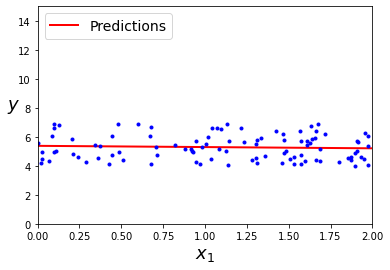

In [2]:
# Existe una resolución analítica (exacta) a la minimización del MSE (la ecuación normal):
#
#    sigma = (X^T * X)^⁻1 * X^T * y
#
# Donde X^T es la traspuesta de X, ^-1 indica la inversa e y es el vector de valores de la variable objetivo. Por 
# supuesto este entrenamiento es supervisado, y lo que se obtiene es el sigma que mejor aproxima al train set.

X = 2 * np.random.rand(100,1)
y = 4 + 3 * np.random.rand(100,1)

# Computando la ecuación normal se obtiene:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print('El valor de Theta es: ')
print(theta_best)

# Para ver una predicción:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict


# Se pinta para tener una imagen mas visual:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()


In [3]:
# Usando sklearn es todavia más facil:

# Se entrena el modelo
lin_reg = LinearRegression()
lin_reg.fit(X,y)
print('El valor del intercepto es:' + str(lin_reg.intercept_))
print('El valor del coeficiente es:' + str(lin_reg.coef_))
# Se predice el valor:
print('La predicción es:')
print(lin_reg.predict(X_new))


El valor del intercepto es:[5.37831725]
El valor del coeficiente es:[[-0.0849451]]
La predicción es:
[[5.37831725]
 [5.20842705]]


Existen otra serie de funciones similares, como la funcion np.linalg.lstsq() o np.linalg.pinv(X).dot(y) que realizan lo mismo, y en las cuales se basa el método de sklearn. Se basa en el uso de la matriz estándar de factorización mediante SVD (Singular Value Decomposition). Esta técnica se basa en la decomposición de la matriz X en tres matrices U epsilon y V^T, y soluciona el problema que presenta la ecuación normal para aquellos casos en los que la matriz X no es invertible, es decir, no se puede realizar X^T * X, como en aquellos casos en los que m>n o existen variables redundantes. SVD utiliza la pseudoinversa, que siempre esta definida, y viene dada por X^+ = V * epsilon^+ * U^T 

La complejidad computacional de cada caso viene determinada por la cantidad de operaciones necesarias. En el primer caso viene dada por por la complejidad de la inversión de la matriz (O(n^2.4) o O(n^3)), y en el segundo caso por O(n^2).
 
Para la complejidad de predicción, se sigue la forma O(n), es decir, doblar el número de predicciones dobla el tiempo.

<h2> Gradient descent </h2>

Gradient descent es un algoritmo genérico que consiste en iterar sobre una serie de parámetros buscando minimizar una función de coste. El ejemplo típico es el de encontrar el mínimo en una distribución parabólica dando pequeños pasos mientras se utiliza el absoluto de la pendiente como función de coste. En la versión más típica se empieza por un valor aleatorio de los parámetros a iterar, y tomando pequeños "pasos" se llega a un mínimo de la función de coste (o solución).

El tamaño de los "pasos" viene dado por el learning rate. Muy pequeño tarda demasiado en converger, muy grande puede que no converja.

Depende de la función de coste puede que existan mínimos locales, huecos y cosas raras. Algunas como el MSE (mínimos cuadrados) siempre convergen, en este caso por ser cuadrática. Como se ha explicado, lo mas importante es definir una correcta función de coste para encontrar una buena combinación de parámetros del modelo. 

También, cuanto mayor sea el espacio de parámetros del modelo, mas dificil será encontrar la solución óptima.


<h3> Batch Gradient Descent </h3>

Para implementar el Gradient Descent debes hacer el gradiente (es decir, el conjunto de derivadas parciales de todas las dimensiones que definan tu sistema). La formula resultante es la siguiente:

    grad(MSE(sigma))=(2/m)*X^T*(X*sigma-y)

En esta fórmula se utiliza el total del training set X para cada paso. Por eso se llama Batch Gradient Descent. Este algoritmo es muy lento en training sets grandes, pero escala bien al aumentar el número de variables.

Una vez se ha calculado el vector gradiente se puede definir un step como:

    sigma(next_step) = sigma - eta*grad(MSE(sigma))

Donde eta es el learning rate de la funcion.

[[ 5.37831725]
 [-0.0849451 ]]


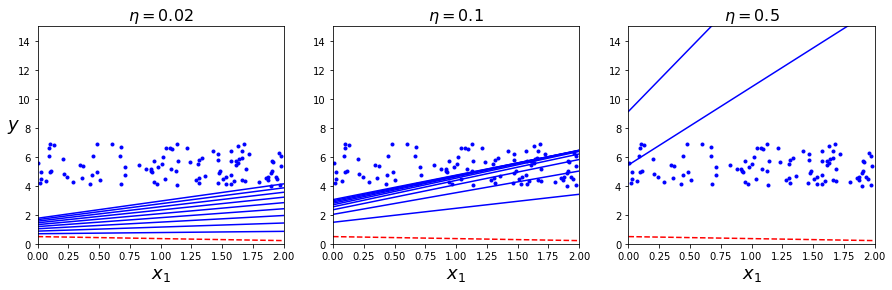

In [4]:
# Viendo una implementación rápida del algoritmo:

eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = (2/m) * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta-eta*gradients
    
print(theta)

# Como se ve se llega al mismo resultado que la ecuación normal. Si cambias el learning rate puede que alteres el 
# comportamiento de la solución (muy pequeño tarda demasiado en converger, muy grande diverge)

# Código copiado de github:

theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(15,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()


Para encontrar el learning rate correcto se puede usar un grid search (limitando el número de iteraciones).

La forma sencilla de limitar el número de iteraciones es utilizar una tolerancia (un valor muy bajo de cambio del gradiente) a partir de la cual podemos decir al algoritmo que pare porque la mejora es inapreciable.

Existe un trade-off entre tolerancia y tiempo empleado. la relación es O(1/tolerancia), es decir, reducir la tolerancia por 10 hace que el algoritmo tarde 10 veces más.

<h3> Stochastic Gradient Descent </h3>

Como el Batch GD tiene el problema de ser lento por coger todo el dataset, el Stochastic GD coge únicamente un registro aleatorio para cada paso, acelerando mucho el algoritmo. Sin embargo, esto le hace ser bastante menos regular que el Batch GD, haciendo que nunca alcance el mínimo absoluto, si no que pivota en torno a el. La solución final es buena, pero no óptima. 

Una solución es reducir el learning rate a medida que avanzan las iteraciones mediante un learning schedule.

Hay que afinar bien este parámetro para no eternizarse ni quedarse a medio camino de la solución.

In [5]:
# Un ejemplo:

n_epochs = 50
t0,t1 = 5,50

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi=X_b[random_index:random_index+1]
        yi=y[random_index:random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta-eta * gradients
        
print(theta)

# Como se ve, da un resultado similar.

# Se puede utilizar SGD para hacer una regresión lineal con Scikit-Learn con SGDRegressor:
# Los atributos clave son el n de iteraciones max_iter, la tolerancia tol, el learning rate eta0 y la 
# regularización penalty

sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())
print([sgd_reg.intercept_,sgd_reg.coef_])


[[ 5.33444021]
 [-0.07317926]]
[array([5.35010571]), array([-0.06906332])]


<h3>Mini-batch Gradient Descent</h3>

El Mini-batch en lugar de coger todos los registros o solo uno al azar, coge un pequeño set de registros al azar para cada paso. La principal ventaja de este método es que puedes paralelizar las tareas usando hardware.

Batch GD, Stochastic GD y Mini-batch GD se ejecutan utilizando SGDRegressor de SKLearn.

No hay casi diferencia entre estos algoritmos a la hora de analizar los resultados.

<h2> Regresión Polinómica </h2>

El valor original de X y su valor al cuadrado es:
[2.15290063 4.63498111]
El valor de la regresión polinómica es
Intercepto: [2.28405711], Coeficientes:[[0.88171323 0.44446033]]


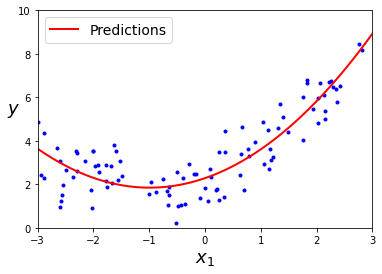

In [6]:
# Para datos que no son una línea recta se puede utilizar la regresión polinómica para ajustarlos. Por ejemplo:

m = 100
X = 6*np.random.rand(m,1)-3
y= 0.5*X**2 + X + 2 + np.random.randn(m,1)

# El dato tiene la forma 0.5X^2 + X + 2 + ruido gaussiano

poly_features = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_features.fit_transform(X)
print("El valor original de X y su valor al cuadrado es:")
print(X_poly[0])

# Ahora se puede entrenar una regresión lineal con este dataset extendido (al cuadrado):
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
print("El valor de la regresión polinómica es")
print('Intercepto: ' + str(lin_reg.intercept_)+', Coeficientes:'+str(lin_reg.coef_))

# Código copiado:

X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Cuando existen multiples variables, la regresión polinómica es capaz de encontrar relaciones entre ellas. 

Por ejemplo, si tenemos dos variables a y b, el objeto PolynomialFeatures con degree=3 encontraría las relaciones a³,b³, a², a²b, b², b²a, ab, a y b

<h3>Curva de Aprendizaje</h3>

Con un polinomio de orden alto puedes aproximar cualquier cosa, pero causarás un overfitting. El problema en general es decidir la complejidad de tu modelo para no hacer overfitting ni underfitting.

La forma mas simple es la vista en el notepad de classification, utilizando un cross-validation. Otra forma es mirar a la curva de aprendizaje, que es la representación del desempeño del modelo en el training y validation set. Para generar las representaciones solo hay que entrenar el modelo varias veces en distintos subsets:

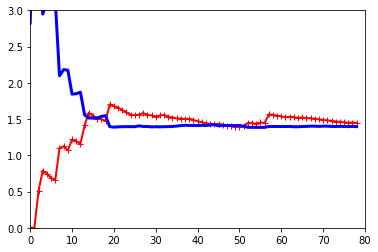

In [7]:
def plot_learning_curves(model,X,y):
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)
    train_errors,val_errors = [],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict=model.predict(X_train[:m])
        y_val_predict=model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        val_errors.append(mean_squared_error(y_val,y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    
    
#Probando con un ejemplo de linear regression:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X,y)
plt.axis([0, 80, 0, 3])
plt.show()

Como se ve, llega un momento en que no mejora porque la distribución de los datos no es lineal (y tiene ruido). Esto es una curva de aprendizaje típica de un underfitting. Las dos curvas de aprendizaje alcanzan un plateau y es relativamente alto.

Comparandolo con el learning curve de un polinomio de orden 10:

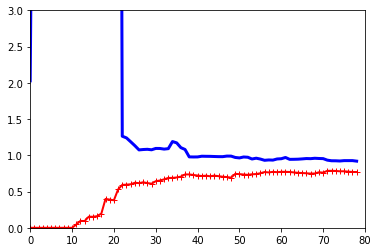

In [8]:
polynomial_regression = Pipeline([
    ("poly_features",PolynomialFeatures(degree=10,include_bias=False)),
    ("lin_reg",LinearRegression()),
])
plot_learning_curves(polynomial_regression,X,y)
plt.axis([0, 80, 0, 3])
plt.show()

Como se ve, el error es mucho mas bajo, y el gap entre train y validation se amplifica (overfitting)

<h3>Bias/Variance Tradeoff</h3>

Un aspecto importante de los modelos de ML y estadística es que toda generalización de error de un modelo se 
puede expresar como suma de tres términos:
- Bias (sesgo): debido a asunciones erróneas, como asumir que la distribución de unos datos es lineal cuando en realidad es cuadrática. Un Bias alto produce underfitting.
- Variance (varianza): se debe a una excesiva sensibilidad del modelo a pequeñas variaciones del training data. Por ejemplo, un modelo con demasiados grados de libertad. Da como resultado overfitting.
- Error irreducible: debido al ruido inherente al dato. Sólo se "soluciona" limpiando el dato.

Mayor complejidad en un modelo reducirá el Bias y aumentará la varianza (y viceversa) -> Bias/Variance Tradeoff.

<h2>Modelos Lineales Regularizados</h2>

Una buena forma de reducir el overfitting es regularizar el modelo (constrain). A menos grados de libertad, más difícil será que haga overfitting. Una forma simple de regularizar un modelo polinómico es quitarle grados.

Para un modelo lineal, la forma típica es imponer ligaduras a los pesos del modelo. Tres formas distintas de hacer esto son:

    - Ridge Regression
    - Lasso Regression
    - Elastic Net

<h3>Ridge Regression</h3>

La regresión de Ridge (o Regularización de Tikhonov) es una versión regularizada de la regresión lineal. Se le añade un término de regularización a la función de coste, dado por:

    alpha*sum(theta_i)²             ,con i=1...n
   
Esto obliga al algoritmo a ajustarse al dataset dejando los pesos lo mas pequeños posible.

Es importante destacar que la regularización sólo se añade durante el entrenamiento del modelo.

Es común que la función coste usada durante el entrenamiento sea distinta de la medida de rendimiento usada para testing. Esto se hace porque una buena función coste permite optimizar el modelo mas fácilmente- (p.e. entrenar con log coss y evaluar con precision/recall).

El parámetro alpha controla cuánto se quiere regularizar el modelo. Si alpha=0 es simplemente un modelo lineal. Si alpha es demasiado alto, todos los valores del modelo serán 0 y el resultado será una linea en el promedio de los datos. La función de coste de Ridge viene representada por la siguiente expresión:

    J(sigma) = MSE(sigma) + alpha*(1/2)*sum(theta_i)²          ,con i=1...n

Cabe destacar que el término Bias sigma_0 no está regularizado, ya que el sumatorio de sigma empieza en i=1. Definiendo omega como el vector de los pesos sigma_1...sigma_n, el término de regularización es simplemente 1/2*(||omega||_2)², donde ||omega||_2 representa la l_2 norma del vector de pesos. Para el Gradient Descent sólo hay que añadir sigma*omega al MSE Gradient Vector (añadir los pesos ponderados).

Se puede crear una ecuación cerrada de la Ridge Regression: theta^ = (X^T*X+alpha*A)^-1 * X * y

Donde A es la matriz identidad (n+1)x(n+1) excepto el primer término, que es un 0 (termino Bias).

Lo interesante, cómo se usa en Sklearn:

In [9]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

# Con solver='cholesky' :‘cholesky’ uses the standard scipy.linalg.solve function to obtain a closed-form solution.
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
print(ridge_reg.predict([[1.5]]))

# Con solver='sag' :‘sag’ uses a Stochastic Average Gradient descent, and ‘saga’ uses its improved, 
# unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster 
# than other solvers when both n_samples and n_features are large. Note that ‘sag’ and ‘saga’ fast 
# convergence is only guaranteed on features with approximately the same scale. You can preprocess 
# the data with a scaler from sklearn.preprocessing.
#unbiased version named SAGA
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
print(ridge_reg.predict([[1.5]]))

# Y usando Stochastic Gradient Descent: 
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

# El término penalty='l2' hace referencia a que quieres añadir un término de regularización a la función de coste
# igual a la mitad del cuadrado de la norma de l2 de los pesos del vector (Ridge Regression).


[[1.51613908]]
[[1.51501427]]
[1.47777591]


<h3>Lasso Regression</h3>

Least Absolute Shrinkage and Selection Operator Regression (LASSO Regression) es otra versión regularizada de regresión lineal. Mientras que Ridge añadía un término de 1/2 del cuadrado de la l_2 norma sobre la función de coste, Lasso añade un término de norma l_1:
    
    J(sigma) = MSE(sigma) + alpha*sum(theta_i)           , con i=1...n
    
Una característica de Lasso es que tiende a eliminar totalmente el peso de aquellas variables menos relevantes para el proceso (manda los pesos de estas a cero). Es decir, si tenemos un polinomio de orden 10 y la mayor parte del peso se reparte entre 4 términos, Lasso va a mandar los otros 6 a cero.

A medida que se va entrenando una Lasso Regression sobre ciertos datos, la aportaión de la penalización l_1 se va reduciendo hacia 0 (al igual que en la Ridge Regression). Sin embargo, mientras que en la Ridge tiende a 0, en la Lasso oscilará cerca de 0 sin llegar a alcanzar dicho valor (por la asimetría del término lineal en contraposición a la simetría del término cuadrático).

La función de coste Lasso no es diferenciable a theta_i=0 (para i=1...n), pero si se utiliza un vector subgradiente g cuando theta_i=0 es posible utilizar un Gradient Descent con la función de coste Lasso:

    g(theta,J) = grad(theta)*MSE(theta) + alpha*(signo(theta))           , con signo(theta) el signo de theta_i
    
En Sklearn se usa asi:

In [10]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
print(lasso_reg.predict([[1.5]]))

[1.56381987]


<h3>Elastic Net</h3>

Elastic Net es una regularización intermedia entre Ridge y Lasso. El término de regularización es una mezcla de un término Ridge y un término Lasso:

    J(theta) = MSE(theta) + r*alpha*sum(|theta_i|) + (1-r)/2 * alpha * sum(theta_i²)          ,con i=1...n

Como se ve, si r=0 es una Ridge, y si r=1 es una Lasso.

El seleccionar un modelo u otro depende de la intuición que se tenga sobre los datos. Si no se sabe qué variables influyen sobre el comportamiento de los datos, Ridge es un buen default. Si se cree que sólo unas pocas variables afectan, es mejor Lasso o Elastic Net.

En general es mejor Elastic Net que Lasso ya que Lasso es errático cuando el número de componentes es mayor que el número de instances o cuando varias componentes están fuertemente correlacionadas.

Así se usa Elastic Net en Sklearn:

In [11]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
print(elastic_net.predict([[1.5]]))

[1.54827848]


<h3>Early Stopping</h3>

Otra aproximación para regularizar algoritmos iterativos es el early stopping. Consiste en detener el entrenamiento tan pronto como el error de validación alcance un mínimo (o un umbral). Es importante que sea sobre el error en el set de validación, ya que si no se tiende al overfitting. En el caso de Stochastic o Mini-Batch GD no se alcanza un mínimo, si no que se oscila en torno a él. Por eso se utiliza un valor umbral.

Un ejemplo de implementación simple de Early Stopping:

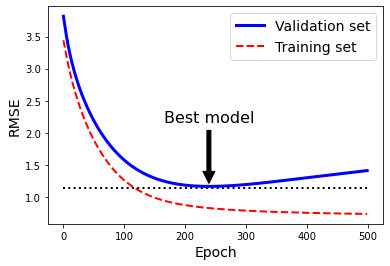

In [12]:
# Preparar los datos:

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

# Ejemplo de Early Stopping
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
    ("poly_features",PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimun_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error< minimun_val_error:
        minimun_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        
# Al poner warm_start = True, el .fit() hace que entrene desde donde lo dejó en la anterior epoch, no 
# desde el principio

# Se crea la gráfica:

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()


In [13]:
# Y este es el modelo bueno:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
        verbose=0, warm_start=True))

<h2>Regresión Logística</h2>

La regresión logística es un algoritmo de regresión que se utiliza para la clasificación binaria de elementos. Básicamente etiqueta como un 1 toda aquella probabilidad superior al 50%, y como 0 toda aquella inferior.

<h3>Estimación de Posibilidades</h3>

Igual que un modelo lineal, computa la suma ponderada de las variables incluidas (sumando un término Bias), pero en lugar de utilizar el resultado directamente, el output es el "logistic" del resultado:

    p^ = h_sigma(x) = sigmoid(x^T * theta)
    
La función logistic (sigmoid) es una función S-shaped que devuelve un número entre 0 y 1. Viene dada por la siguiente expresión:
    
    sigmoid(t) = 1/(1+exp(-t))

Y representada por la siguiente gráfica:

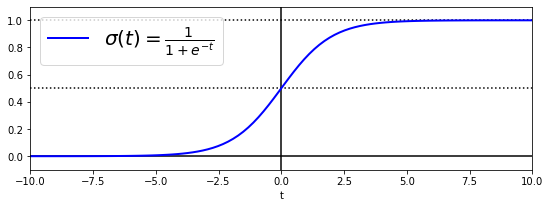

In [17]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

Una vez el modelo logístico ha estimado la probabilidad p^=h_theta(x) de si una instancia correspondea la clase positiva, puede hacer la predicción de ŷ muy facil:

    ŷ = [0 si p^<0.5, 1 si p^>=0.5] 
    
El término t a veces se conoce como logit.
    
    

<h3>Entrenamiento y función coste</h3>

Para entender cómo se entrena: el objetivo es establecer el vector de parámetros (theta) para que el modelo estube la mayor probabilidad para las instancias positivas (y=1), y la menor para las negativas (y=0). La idea viene representada en la funcion coste para una única instancia de entrenamiento:

    c(theta) = [-log(p^) si y=1, -log(1-p^) si y=0
    
Esta función coste cumple su cometido porque -log(t) crece muy rapido a medida que t se acerca a 0. Así el coste será muy alto cuando el modelo estime una probabilidad cercana a 0 para una instancia positiva, o a 1 para una instancia negativa. Por otro lado, -log(t) tiende rápido a 0 cuando t tiende a 1, lo que provoca que el coste de una instancia positiva que el modelo estima cercana a 1 tiende rápido a 0, y lo mismo para una instancia negativa cercana a 0. Esto es justo lo que se busca.

La función coste de todo el training set es simplemente el promedio de todas las funciones coste del set. Esto es llamado el log loss, y se expresa como:

    J(theta) = -1/m * sum[y^i * log(p^ ^i) + (1-y^i) * log(1-p^ ^i)]          ,con i=1...m
    
No existe una ecuación cerrada para el valor de theta, pero la función coste es convexa, así que un Gradient Descent (o cualquier otro algoritmo de optimización) garantiza encontrar el mínimo global (a no ser que se elijan mal los learning rate). Las derivadas parciales de la función coste vienen dadas por la siguiente expresión:

    (dJ(theta))/(dtheta_j) = 1/m * sum(sigmoide(theta^T * x^i) - y^i) * x^i_j              , con i=1...m
    
Esta ecuación se parece mucho a la del Gradient Descent: para cada instancia se computa el error de predicción y se multiplica por el valor de la variable j, calculando despues el promedio sobre todas las instancias. Una vez tienes el vector gradiente conteniendo todas las derivadas parciales, se puede usar en un Batch Gradient Descent. También se puede coger una única instancia para un Stochastic GD o un mini-batch para hacer un Mini-Batch GD.

<h3>Decision Boundaries</h3>

Para la explicación de los decision boundaries se va a usar el dataset Iris. Tiene los tamaños de sépalo y pétalo de 150 flores de 3 variedad de iris: iris-setosa, iris-versicolor e iris-virginica.

La idea es construir un clasificador para las iris-virginica solo utilizando el ancho del pétalo:

In [15]:
iris = datasets.load_iris() 
# Lo primero es ver qué tiene el dataset:
print(list(iris.keys()))
print(iris['data'].shape)
# Lo que interesa es de 'data' la columna 4 (se ve en el siguiente enlace)
# https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
X = iris.data[:,3:]
y = (iris.target == 2).astype(np.int) # si el target es 2 es que es virginica, asi que virginica = 1, 0 si no

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']
(150, 4)


/home/kiko/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


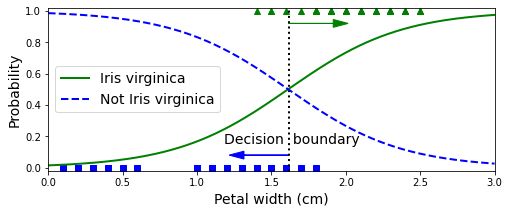

[1 0]


In [16]:
# Vamos a entrenar un Logistic Regression para clasificar esto:
log_reg = LogisticRegression()
log_reg.fit(X,y)
# Vamos a ver que estima el modelo solo con el ancho de los pétalos entre 0 y 3cm

X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

# Ejemplos cercanos al decision boundary:
print(log_reg.predict([[1.7],[1.5]]))

Los anchos de pétalo de las virginica van de 1.4 a 2.5 cms. Las otras clases de iris tienen pétalos con un ancho de entre 0.1 y 1.4 cm. Esto explica un poco el solapamiento donde el clasificador no es capaz de distinguir demasiado bien. Sin embargo, si preguntas usando el predict al clasificador, te dirá lo que sea más probable: si está sobre el decision boundary te dirá Virginica, si está por debajo te dirá no Virginica.

Cuando se utiliza una única variable para predecir, el decision boundary es un punto. Si se usan dos variables es una linea sobre estos valores. Así, escala con el número de variables. Además se pueden definir porcentajes de confianza a partir de este decision boundary y la confianza del modelo sobre la predicción que realiza.

También, como en el resto de modelos lineales, se puede regularizar un Logistic Regression usando l1 y l2 penalties. Sklearn añade l2 por defecto.

Nota: el parámetro que controla la regularización en un Sklearn LogisticRegression model no es alpha si no su inversa C (cuanto mayor es C, mas bajo es el peso del parámetro regulador).

<h3>Regresion Softmax</h3>

La regresión Logistica se puede generañizar para soportar varias clases en lugar de sólo una, sin tener que entrenar múltiples clasificadores binarios. Esto es llamado Softmax Regression o Multinomial Logistic Regression.

La idea es simple. Para cada instancia x, la Softmax calcula un score s_k(x) y estima la probabilidad de cada clase aplicando la softmax function (exponencial normalizada) a los scores. Esta ecuación que calcula s_k(x) es similar a la ecuación de predicción de Linear Regression:

    s_k(x) = x^T * theta^(k)
    
Cada clase tiene su vector de parametros theta^(k). Esos vectores se suelen guardar como filas es una matriz de parámetros Theta.

Una vez tienes calculados los score de cada una de las clases de la instancia x, se puede estimar la probabilidad p^_k de que una instancia corresponda a una clase k pasando los scores por la funcion softmax. Calcula la exponencial de cada score y la normaliza. Los scores se llaman normalmente logits o log-odds (aunque son realmente unnormalized log-odds).

La ecuación softmax tiene la siguiente forma:

    p^_k = sigma(s(x))_k = exp(s_k(x)) / sum(exp(s_j(x))           , con j=1...K
    
Aquí K es el número de clases distintas, s(x) son los scores de cada clase para la instancia x, sigma(s(x))_k es la probabilidad estimada de que la instancia x pertenezca a la clase k dados los score s de esa instancia.

Igual que la Logistic Regression, la Softmax predice la clase con la probabilidad estimada más alta:

    y^ = argmax(sigma(s(x))_k)_k = argmax (s_k(x))_k = argmax((Theta^(k))^T * x)_k
    
Aquí argmax es la función que devuelve el valor máximo del vector de probabilidades de x para las clases k (devuelve la clase k_i con una probabilidad mayor para la instancia x).

Esto hace que la Softmax devuelva un único valor para la clase, así que se debe utilizar únicamente con clases que se excluyan entre sí (p.e. no se puede utilizar para reconocer varias personas en una imagen).

A la hora de entrenar, se busca que el modelo obtenga una probabilidad alta de la clase correcta y baja en el resto. La función coste a minimizar para conseguir esto es la Cross Entropy (no se usa sólo para la Softmax, es bastante común para los clasificadores multiclase).

    J(theta) = -1/m * sum(y^(i) * log(p^ ^(i)_k))                    ,con i=1...m y k=1...K

Donde y^(i) es la probabilidad de que la instancia i pertenezca a la clase k. En general es 1 o 0.

Nota: La Cross Entropy se originó para optimizar la transmisión de información. Por ejemplo, si tienes 8 estados posibles para el clima (soleado, lluvioso, nublado...) puedes codificarlo en 3 bits (porque 2³=8), pero si por ejemplo casi siempre está soleado, es mucho mas eficiente codificar el soleado en un bit (p.e. 0) y el resto de estados en 4 bits. Si tu asumpción es correcta la cross entropy será igual a la entropía del sistema (casi 0), pero si es incorrecta (no suele ser soleado), la cross entropy crecerá en una cantidad llamada divergencia de  Kullback-Leibler. La Cross Entropy entre dos probabilidades p y q es H(p,q) = -sum(p(x)log(q(x))  cuando las dos distribuciones sean discretas.

El vector gradiente para la Cross Enrtropy dada por Theta^(k) viene dado por la siguiente expresión:

    grad_(Theta,k) J(Theta) = 1/m * sum(p^_k^(i) - y_k^(i) ) *x^(i)
    
Con esto ya se puede calcular el vector gradiente para cada clase y después usar un algoritmo de optimización (p.e. Gradient Descent) para encontrar el parámetro Theta que minimiza la función coste.

Vamos a ver un ejemplo de la Softmax en el dataset Iris. Sklearn usa LogisticRegression en un one-vs-all por defecto cuando usas mas de dos clases, pero puedes cambiar el parámetro multi_class a 'multinomial' para cambiarlo a una Softmax. Además se debe especificar el solver para la Softmax (p.e. 'lbfgs'). Además aplica por defecto la regularización l2 (que se puede controlar con el parámetro C, la inversa de alpha).

In [22]:
# Esta vez, en vez de coger solo el ancho del pétalo, cogemos también el largo
X = iris.data[:,(2,3)]
y = iris.target

softmax_reg = LogisticRegression(multi_class='multinomial',solver='lbfgs',C=10)
softmax_reg.fit(X,y)

# Vamos a ver un predict:

print(softmax_reg.predict([[5,2]])[0])
print(softmax_reg.predict_proba([[5,2]])[0])

2
[6.38014896e-07 5.74929995e-02 9.42506362e-01]


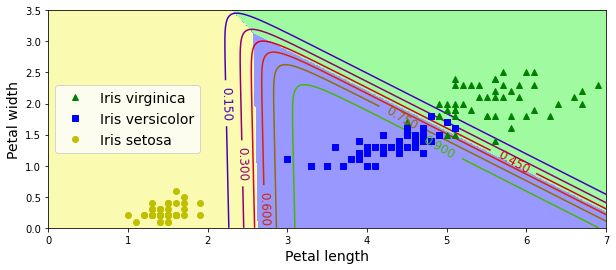

In [23]:
# Vamos a ver cómo se distribuiria el decision boundary de esto:


x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")


custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()